In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import TensorDataset, DataLoader
import psycopg2
from pgvector.psycopg2 import register_vector
from config import HOST, DBNAME, USERNAME, PASSWORD

/home/nicek/Projects/multitask_learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def low_rank_approximation(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    return U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

In [3]:
def low_rank_projection(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    return U[:, :k] * S[:k] 

In [4]:
def random_projection(latent: np.ndarray, k: int):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    R = np.random.randn(384, k) / np.sqrt(k)
    return latent @ R

In [5]:
def make_dataloader(X, y, batch_size=64):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class ClassiNet(nn.Module):
    def __init__(self, input_dim, num_label=77):
        super(ClassiNet, self).__init__()
        self.classi = nn.Linear(input_dim, num_label)
    
    def forward(self, x):
        return self.classi(x)

epochs = 10

# One pass
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data, label in loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    return 100 * correct / total

In [7]:
conn = psycopg2.connect(
    host=HOST,
    dbname=DBNAME,
    user=USERNAME,
    password=PASSWORD,
)

split = "_test"
dataset_name = "Banking77Classification" + split

# pgvector query
register_vector(conn)
curr = conn.cursor()
curr.execute(
    """
SELECT * FROM vectors
WHERE dataset_id = (
    SELECT id FROM vector_datasets
    WHERE name = %s
);
""",
    (dataset_name,),
)
tests = curr.fetchall()

split = "_train"
dataset_name = "Banking77Classification" + split

curr.execute(
    """
SELECT * FROM vectors
WHERE dataset_id = (
    SELECT id FROM vector_datasets
    WHERE name = %s
);
""",
    (dataset_name,),
)

trains = curr.fetchall()
curr.close()
conn.close()

train_embedding = np.array([row[2] for row in trains])  # (10003, 384)
train_labels = np.array([row[5] for row in trains])  # (10003, ) min 155, max 231
train_labels -= 155

test_embedding = np.array([row[2] for row in tests])  # (3080, 384)
test_labels = np.array([row[5] for row in tests])  # (3080, 384)
test_labels -= 78


a = input("Label1: ")
a = int(a) if a else -1
b = input("Label2: ")
b = int(b) if b else -1

# if a == -1 and b == -1:
#     mask = None
# else:
#     mask = (labels == a) | (labels == b)

# if mask is not None and np.any(mask):
#     embedding = embedding[mask]
#     labels = labels[mask]

if a == -1 and b == -1:
    train_mask = test_mask = None
else:
    train_mask = (train_labels == a) | (train_labels == b)
    test_mask = (test_labels == a) | (test_labels == b)
if train_mask is not None and np.any(train_mask) and np.any(test_mask):
    train_embedding = train_embedding[train_mask]
    test_embedding = test_embedding[test_mask]
    train_labels = train_labels[train_mask]
    test_labels = test_labels[test_mask]

    # Map to 0, 1 for ClassiNet <3
    label_map = {a: 0, b: 1}
    train_labels = np.vectorize(label_map.get)(train_labels)
    test_labels = np.vectorize(label_map.get)(test_labels)
print(f"{train_embedding.shape=}")
print(f"{test_embedding.shape=}")

train_embedding.shape=(10003, 384)
test_embedding.shape=(3080, 384)



[LOG] Running for k = 70
Epoch 5: Loss=3.2736 | Test Acc=7.95%
Epoch 10: Loss=2.3356 | Test Acc=8.70%

[LOG] Running for k = 71
Epoch 5: Loss=3.2769 | Test Acc=7.82%
Epoch 10: Loss=2.3351 | Test Acc=8.93%

[LOG] Running for k = 72
Epoch 5: Loss=3.2677 | Test Acc=7.92%
Epoch 10: Loss=2.3241 | Test Acc=8.83%

[LOG] Running for k = 73
Epoch 5: Loss=3.2712 | Test Acc=7.92%
Epoch 10: Loss=2.3229 | Test Acc=8.90%

[LOG] Running for k = 74
Epoch 5: Loss=3.2627 | Test Acc=7.44%
Epoch 10: Loss=2.3147 | Test Acc=8.38%

[LOG] Running for k = 75
Epoch 5: Loss=3.2680 | Test Acc=7.76%
Epoch 10: Loss=2.3135 | Test Acc=8.41%

[LOG] Running for k = 76
Epoch 5: Loss=3.2695 | Test Acc=7.73%
Epoch 10: Loss=2.3127 | Test Acc=8.25%

[LOG] Running for k = 77
Epoch 5: Loss=3.2606 | Test Acc=7.05%
Epoch 10: Loss=2.3030 | Test Acc=8.54%

[LOG] Running for k = 78
Epoch 5: Loss=3.2557 | Test Acc=7.05%
Epoch 10: Loss=2.2971 | Test Acc=8.41%

[LOG] Running for k = 79
Epoch 5: Loss=3.2504 | Test Acc=7.53%
Epoch 10:

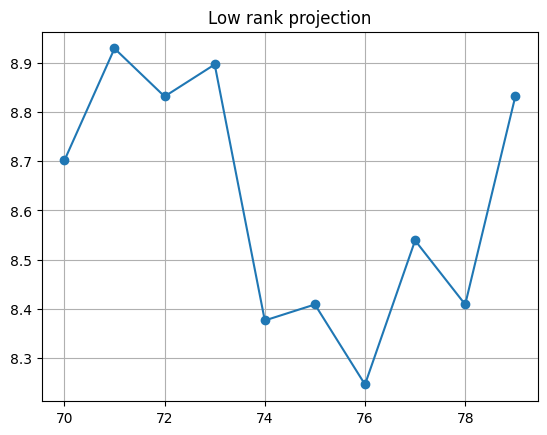

In [8]:
# Same old function
K = [i for i in range(70,80)]
results = []

for k in K:
    print(f"\n[LOG] Running for {k = }")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = make_dataloader(low_rank_projection(train_embedding, k), train_labels)
    test_loader = make_dataloader(low_rank_projection(test_embedding, k), test_labels)

    model = ClassiNet(input_dim=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank projection")
plt.show()


[LOG] Running for k = 70


Epoch 5: Loss=3.0285 | Test Acc=0.81%
Epoch 10: Loss=2.1186 | Test Acc=1.07%

[LOG] Running for k = 71
Epoch 5: Loss=3.0215 | Test Acc=0.19%
Epoch 10: Loss=2.0974 | Test Acc=0.45%

[LOG] Running for k = 72
Epoch 5: Loss=3.0793 | Test Acc=0.58%
Epoch 10: Loss=2.1790 | Test Acc=0.32%

[LOG] Running for k = 73
Epoch 5: Loss=3.0086 | Test Acc=1.07%
Epoch 10: Loss=2.0812 | Test Acc=0.94%

[LOG] Running for k = 74
Epoch 5: Loss=3.0233 | Test Acc=2.60%
Epoch 10: Loss=2.1065 | Test Acc=2.66%

[LOG] Running for k = 75
Epoch 5: Loss=3.0088 | Test Acc=1.07%
Epoch 10: Loss=2.0850 | Test Acc=0.97%

[LOG] Running for k = 76
Epoch 5: Loss=2.9842 | Test Acc=0.55%
Epoch 10: Loss=2.0586 | Test Acc=0.75%

[LOG] Running for k = 77
Epoch 5: Loss=3.0370 | Test Acc=0.78%
Epoch 10: Loss=2.1183 | Test Acc=0.62%

[LOG] Running for k = 78
Epoch 5: Loss=2.9718 | Test Acc=0.81%
Epoch 10: Loss=2.0390 | Test Acc=0.78%

[LOG] Running for k = 79
Epoch 5: Loss=2.9616 | Test Acc=1.66%
Epoch 10: Loss=2.0184 | Test Acc=1.

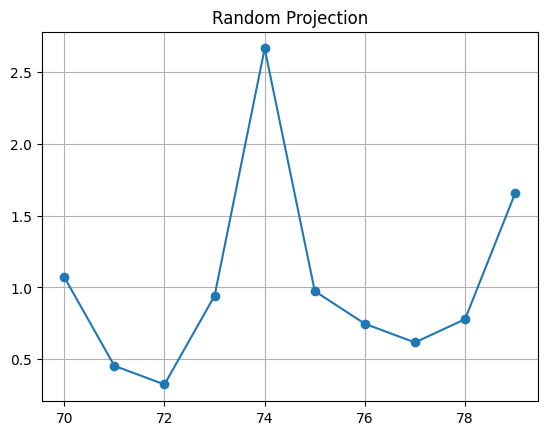

In [9]:
K = [i for i in range(70,80)]
results = []

for k in K:
    print(f"\n[LOG] Running for {k = }")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = make_dataloader(random_projection(train_embedding, k), train_labels)
    test_loader = make_dataloader(random_projection(test_embedding, k), test_labels)

    model = ClassiNet(input_dim=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Random Projection")
plt.show()


[LOG] Running for k = 70


Epoch 5: Loss=1.8738 | Test Acc=80.00%
Epoch 10: Loss=1.0028 | Test Acc=85.10%

[LOG] Running for k = 71
Epoch 5: Loss=1.8711 | Test Acc=79.68%
Epoch 10: Loss=1.0028 | Test Acc=85.16%

[LOG] Running for k = 72
Epoch 5: Loss=1.8735 | Test Acc=79.87%
Epoch 10: Loss=0.9991 | Test Acc=85.16%

[LOG] Running for k = 73
Epoch 5: Loss=1.8719 | Test Acc=79.87%
Epoch 10: Loss=0.9990 | Test Acc=85.26%

[LOG] Running for k = 74
Epoch 5: Loss=1.8753 | Test Acc=79.81%
Epoch 10: Loss=0.9993 | Test Acc=85.23%

[LOG] Running for k = 75
Epoch 5: Loss=1.8683 | Test Acc=79.48%
Epoch 10: Loss=0.9968 | Test Acc=84.94%

[LOG] Running for k = 76
Epoch 5: Loss=1.8646 | Test Acc=80.00%
Epoch 10: Loss=0.9942 | Test Acc=85.32%

[LOG] Running for k = 77
Epoch 5: Loss=1.8731 | Test Acc=79.58%
Epoch 10: Loss=0.9948 | Test Acc=85.42%

[LOG] Running for k = 78
Epoch 5: Loss=1.8667 | Test Acc=79.32%
Epoch 10: Loss=0.9938 | Test Acc=85.52%

[LOG] Running for k = 79
Epoch 5: Loss=1.8686 | Test Acc=79.77%
Epoch 10: Loss=0

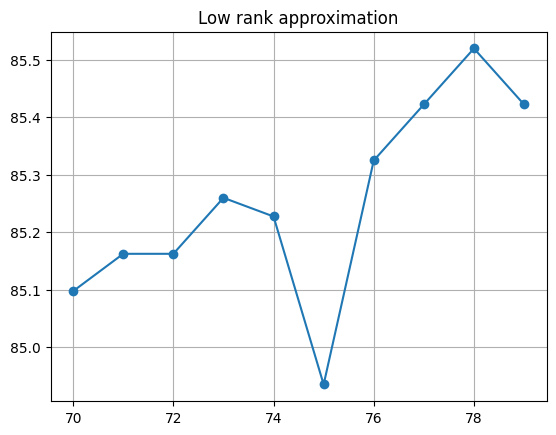

In [10]:
K = [i for i in range(70,80)]
results = []

for k in K:
    print(f"\n[LOG] Running for {k = }")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = make_dataloader(low_rank_approximation(train_embedding, k), train_labels)
    test_loader = make_dataloader(low_rank_approximation(test_embedding, k), test_labels)

    model = ClassiNet(input_dim=384).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank approximation")
plt.show()